In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class HebianNet():
    def __init__(self):
        self.weights = None
        self.trained = False
        
    def train(self,data):
        if not self.trained:
            self.weights = np.zeros((data.shape[1], data.shape[1]))
        for index in range(data.shape[0]):
            self.weights = np.add(np.outer(np.transpose(data[index,:]),data[index,:]),self.weights)
        self.weights = np.divide(self.weights, data.shape[1])
        self.trained = True
    
    def sparse_train(self, data, activity):
        activitiy = np.ones(data.shape)*activity
        data = data - activity
        self.train(data)
    
    def update_batch(self, x):
        new = np.dot(x,self.weights)
        new[new>=0] = 1
        new[new<0] = -1
        return new
    
    def update_asynch(self, x):
        dimension = x.shape[0]
        new = x.copy()
        for i in range(dimension):
            sum_ = 0
            for j in range(dimension):
                sum_ += np.multiply(self.weights[i][j], new[j])
            if sum_ < 0:
                new[i] = -1
            else:
                new[i] = 1
        return new

    def update_sparse(self, x, theta):
        dimension = x.shape[0]
        new = x.copy()
        for i in range(dimension):
            sum_ = 0
            for j in range(dimension):
                sum_ += np.multiply(self.weights[i][j], new[j])
            if sum_ - theta < 0:
                new[i] = 0
            else:
                new[i] = 1
        return new
    
    def update_random(self, x):
        dimension = x.shape[0]
        new = x.copy()
        for count in range(dimension):
            i = np.random.randint(0,dimension)
            sum_ = 0
            for j in range(dimension):
                sum_ += np.multiply(self.weights[i][j], new[j])
            if sum_ < 0:
                new[i] = -1
            else:
                new[i] = 1
        self.plot(new)
        return new        

    
    def recall(self, x, method = "batch", maxiter = None, theta = None):
        error = 1
        itercount = 0
        
        if method == "batch":
            update = self.update_batch
        if method == "asynch":
            update = self.update_asynch
        if method == "random":
            update = self.update_random
        energy = []    
        while error > 0:
            if method == "sparse":
                new = self.update_sparse(x,theta)
            else:
                new = update(x)
            error = sum(abs(new-x))
            x = new.copy()
            itercount += 1
            energy.append(self.energy(x))
            if itercount == maxiter:
                break
        return x, itercount, energy
    
    def energy(self, pattern):
        outer = np.outer(pattern, np.transpose(pattern))
        pos_energy = np.sum(np.multiply(self.weights, outer))
        return np.multiply(-1, pos_energy)
    
    def plot(self, pattern):
        plt.imshow(pattern.reshape(32,32),interpolation="nearest")
        plt.show()

In [27]:
x1 = np.array([-1,-1,1,-1,1,-1,-1,1])
x2 = np.array([-1,-1,-1,-1,-1,1,-1,-1])
x3 = np.array([-1,1,1,-1,-1,1,-1,1])
data  = np.array([x1,x2,x3])

In [28]:
hn = HebianNet()

In [29]:

hn.train(data)

In [30]:
np.count_nonzero(hn.update_batch(x1)-x1)

0

In [31]:
#convergence n attractors
x1d = np.array([1,-1,1,-1,1,-1,-1,1])
x2d = np.array([1,1,-1,-1,-1,1,-1,-1])
x3d = np.array([1,1,1,-1,1,1,-1,1])

In [32]:
np.count_nonzero(hn.recall(x1d)[0]- x1)

0

In [126]:
np.count_nonzero(hn.recall(x2d)[0]- x2)

1

In [127]:
np.count_nonzero(hn.recall(x3d)[0] - x3)

0

In [33]:
searchgrid = np.zeros((256, 8))
for i in range(256):
    arr = [int(x) for x in bin(i)[2:]]
    for j in range(len(arr)):
        searchgrid[i][8 - len(arr) + j] = arr[j]

In [34]:
attractors = np.empty((256,8))
for vec in range(searchgrid.shape[0]):
    result = hn.recall(searchgrid[vec])[0]
    attractors[vec] = result
    nunique = np.unique(attractors, axis=0).shape[0]
print("There are {} attractors in the net".format(nunique))

There are 8 attractors in the net


In [35]:
x1dd = np.multiply(x1,np.array([-1,-1,-1,-1,-1,1,1,1]))

In [36]:
new, iterations, energy = hn.recall(x1dd)
new = np.multiply(new,x1).copy()
result = len(new[new<0])
print("Diff from original in {} elements. Iterations to converge {}".format(result,iterations))

Diff from original in 4 elements. Iterations to converge 3


In [37]:
#sequential update
pictData = np.loadtxt('./pict.dat',delimiter=",", dtype=int).reshape(-1,1024)

In [38]:
trainingData = pictData[0:3].copy()

In [39]:
testData = pictData[3:].copy()

In [40]:
hn = HebianNet()

In [41]:
hn.train(trainingData)

In [42]:
#check stability
test1 = np.multiply(hn.update_batch(trainingData[0]),trainingData[0])
print(len(test1[test1<0]))
test2 = np.multiply(hn.update_batch(trainingData[1]),trainingData[1])
print(len(test2[test2<0]))
test3 = np.multiply(hn.update_batch(trainingData[2]),trainingData[2])
print(len(test3[test3<0]))

0
0
0


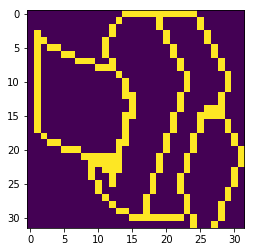

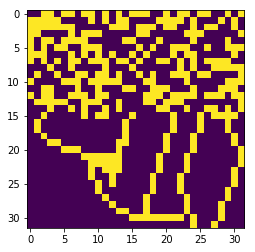

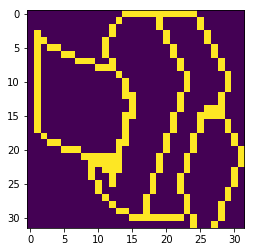

In [138]:
#performance on degraded patterns
p10_recalled = hn.recall(testData[-2])[0]
#Plot picture 1
hn.plot(trainingData[0])
#Plot picture 10, degraded version of picture 1
hn.plot(testData[-2])
#Plot output of HebianNet on picture 11
hn.plot(p10_recalled)


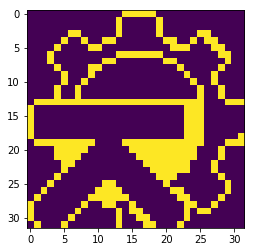

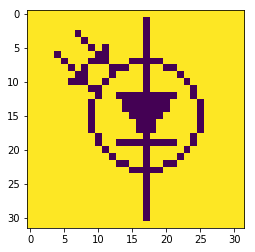

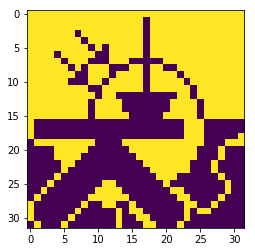

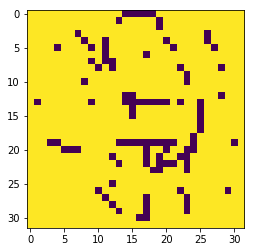

In [139]:
p11_recalled = hn.recall(testData[-1])[0]
#Show picture 2
hn.plot(trainingData[1])
#Show picture 3
hn.plot(trainingData[2])
#Show Picture 11, combination of 2 and 3
hn.plot(testData[-1])
#Show recalled version of picture 11
hn.plot(p11_recalled)

Diff from training pattern is 135
3 iterations


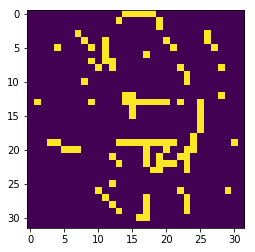

In [140]:
#Using "non - random" sequential updates
p10_arecalled, iter_, energy = hn.recall(testData[-2], method = 'asynch')
diff = np.multiply(p10_arecalled,trainingData[0])
print("Diff from training pattern is {}".format(len(diff[diff<0])))
print("{} iterations".format(iter_))
hn.plot(p10_arecalled)

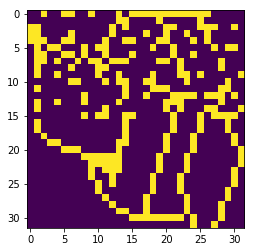

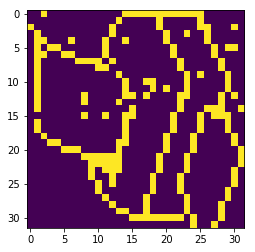

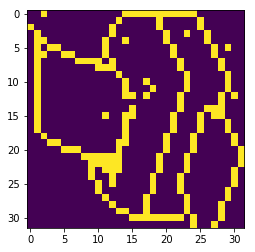

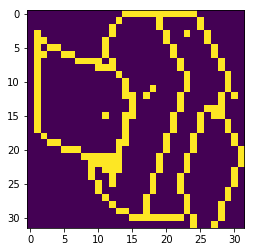

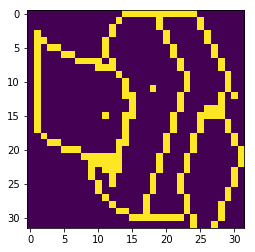

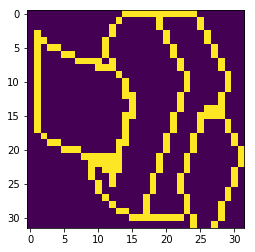

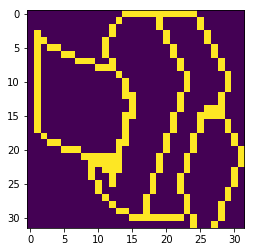

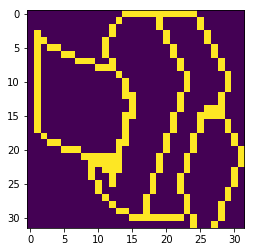

Diff from training pattern is 0
8 iterations


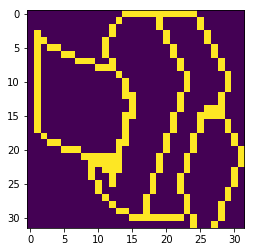

In [141]:
#Using random sequential updates
p10_arecalled, iter_, energy_random = hn.recall(testData[-2], method= 'random')
diff = np.multiply(p10_arecalled,trainingData[0])
print("Diff from training pattern is {}".format(len(diff[diff<0])))
print("{} iterations".format(iter_))
hn.plot(p10_arecalled)

In [142]:
#energy at attractors

for i in range(trainingData.shape[0]):
    print("Energy at picture {} (attractor) was {}".format(i+1,hn.energy(trainingData[i])))

Energy at picture 1 (attractor) was -1439.390625
Energy at picture 2 (attractor) was -1365.640625
Energy at picture 3 (attractor) was -1462.25


In [143]:
#Energy at distorted patterns

for i in range(testData.shape[0]):
    print("Energy at picture {} (distorted) was {}".format(i+4,hn.energy(testData[i])))
hn.energy(testData[-2])

Energy at picture 4 (distorted) was -720.48046875
Energy at picture 5 (distorted) was -525.890625
Energy at picture 6 (distorted) was -683.296875
Energy at picture 7 (distorted) was -685.73046875
Energy at picture 8 (distorted) was -171.546875
Energy at picture 9 (distorted) was -267.51171875
Energy at picture 10 (distorted) was -415.98046875
Energy at picture 11 (distorted) was -173.5


-415.98046875

Text(0.5,1,u'Energy for every iteration(nonrandom)')

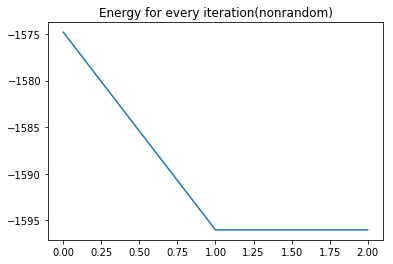

In [49]:
#energy at every asyn iteration
#Non random
plt.plot(energy)
plt.title("Energy for every iteration(nonrandom)")

Text(0.5,1,u'Energy for every iteration')

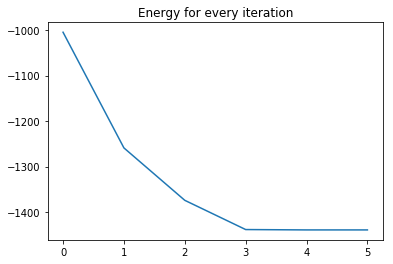

In [50]:
#Random
plt.plot(energy_random)
plt.title("Energy for every iteration")


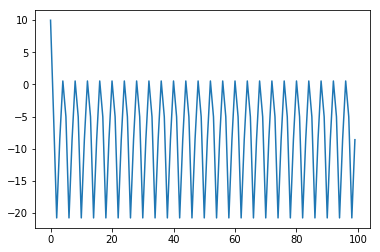

In [70]:
#Generate a weight matrix by setting the weights to normally distributed
#random numbers, and try iterating an arbitrary starting state. What happens?
hn_2 = HebianNet()
dim = 8
hn_2.weights = np.random.randn(dim,dim)
start_state = np.random.randn(8)
recalled, iter_, e = hn_2.recall(start_state, maxiter = 100)
plt.plot(e)
#Doesn't converge

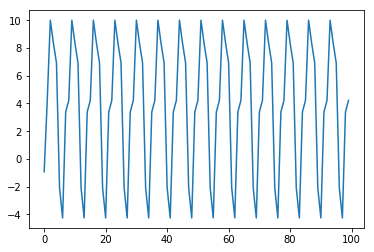

In [82]:
hn_3 = HebianNet()
dim = 8
hn_3.weights = np.random.randn(dim,dim)
hn_3.weights = np.multiply(0.5, hn_3.weights + np.linalg.inv(hn_3.weights))
start_state = np.random.randn(8)
recalled, iter_, e = hn_3.recall(start_state, maxiter = 100)
plt.plot(e)
#Still doesn't really converge?

In [43]:
def distort_data(pattern,percentage):
    dim = pattern.size
    dist = int(dim*percentage)
    
    subDist = pattern[:dist]
    #print(pattern)
    distPattern=np.copy(pattern)
    np.random.shuffle(distPattern[:dist])
    
    #plt.imshow(distPattern.reshape(32,32),interpolation="nearest")
    #plt.show()
    
    return distPattern

original


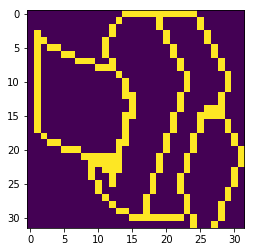

distorting 10.0%


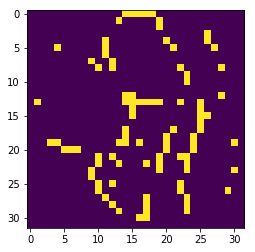

distorting 10.0%


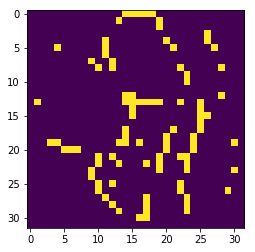

distorting 10.0%


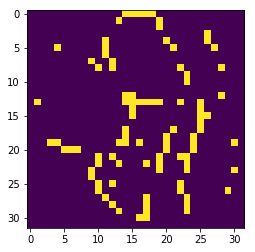

In [45]:
print("original")
hn_cap.plot(trainingData[0])
for percentage in range(3):
    percentage = percentage/10 + 0.1
    dist_pic = distort_data(trainingData[0], percentage)
    recalled, iter_, e = hn_cap.recall(dist_pic, maxiter = 100)
    print("distorting {}%".format(percentage*100))
    hn.plot(recalled)

original


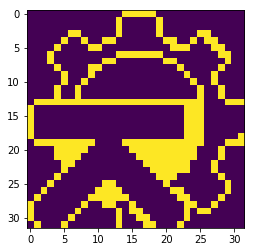

distorting 10.0%


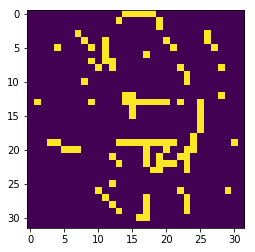

distorting 10.0%


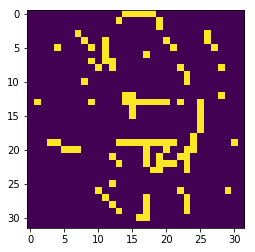

distorting 10.0%


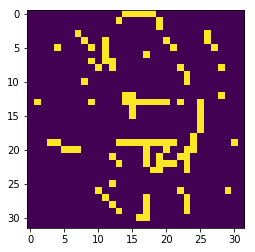

distorting 10.0%


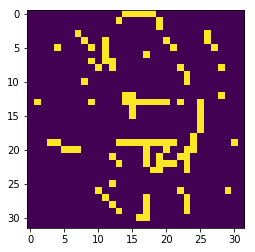

distorting 10.0%


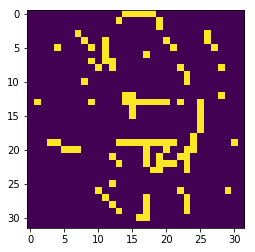

In [46]:
print("original")
hn_cap.plot(trainingData[1])
for percentage in range(5):
    percentage = percentage/10 + 0.1
    dist_pic = distort_data(trainingData[1], percentage)
    recalled, iter_, e = hn_cap.recall(dist_pic, maxiter = 100)
    print("distorting {}%".format(percentage*100))
    hn.plot(recalled)

original


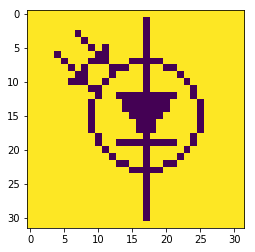

distorting 10.0%


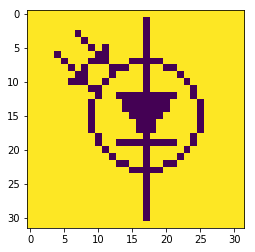

distorting 10.0%


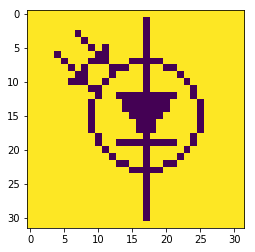

distorting 10.0%


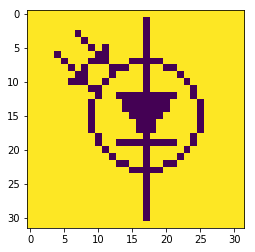

In [47]:
print("original")
hn_cap.plot(trainingData[2])
for percentage in range(3):
    percentage = percentage/10 + 0.1
    dist_pic = distort_data(trainingData[2], percentage)
    recalled, iter_, e = hn.recall(dist_pic, maxiter = 100)
    print("distorting {}%".format(percentage*100))
    hn.plot(recalled)

In [48]:
def calc_error(true_pattern, dist_pattern):
    recalled = hn_cap.recall(dist_pattern)[0]
    res = np.multiply(recalled, true_pattern)
    return len(res[res<0])/len(recalled)*100

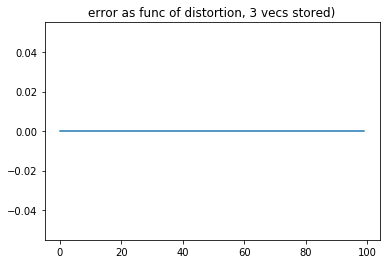

In [49]:
#Train with 3 pics
dim = 3
trainingData = pictData[0:3].copy()
hn_cap = HebianNet()
hn_cap.train(trainingData)

errors = []
for percentage in range(100):
    percentage = percentage/100 + 0.01
    dist_pic = distort_data(trainingData[0], percentage)
    errors.append(calc_error(trainingData[0],dist_pic))
plt.plot(errors)
plt.title("error as func of distortion, {} vecs stored)".format(dim))
plt.show()

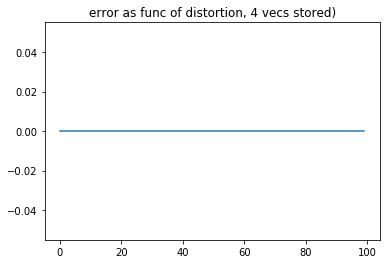

In [50]:
#Train with 4 pics
dim = 4
trainingData = pictData[0:dim].copy()
hn_cap = HebianNet()
hn_cap.train(trainingData)

errors = []
for percentage in range(100):
    percentage = percentage/100 + 0.01
    dist_pic = distort_data(trainingData[0], percentage)
    errors.append(calc_error(trainingData[0],dist_pic))
plt.plot(errors)
plt.title("error as func of distortion, {} vecs stored)".format(dim))
plt.show()

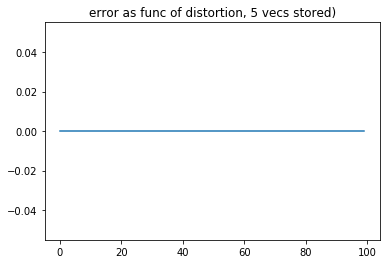

In [51]:
#Train with 5 pics
dim = 5
trainingData = pictData[0:dim].copy()
hn_cap = HebianNet()
hn_cap.train(trainingData)

errors = []
for percentage in range(100):
    percentage = percentage/100 + 0.01
    dist_pic = distort_data(trainingData[0], percentage)
    errors.append(calc_error(trainingData[0],dist_pic))
plt.plot(errors)
plt.title("error as func of distortion, {} vecs stored)".format(dim))
plt.show()

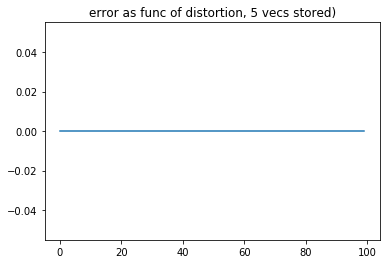

In [52]:
#Train with 6 pics
trainingData = pictData[0:6].copy()
hn_cap = HebianNet()
hn_cap.train(trainingData)

errors = []
for percentage in range(100):
    percentage = percentage/100 + 0.01
    dist_pic = distort_data(trainingData[0], percentage)
    errors.append(calc_error(trainingData[0], dist_pic))
plt.plot(errors)
plt.title("error as func of distortion, {} vecs stored)".format(dim))
plt.show()

In [149]:
def create_random_data(dim):
    training_data = np.random.randn(dim,1024)
    training_data[training_data > 0] = 1
    training_data[training_data <= 0] = -1
    return training_data

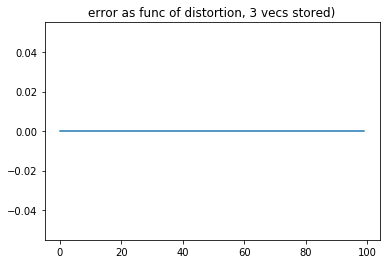

In [150]:
# Store 3 vectors of random data
dim = 3
hn_cap = HebianNet()
trainingData = create_random_data(dim)
hn_cap.train(trainingData)
errors = []
for percentage in range(100):
    percentage = percentage/100 + 0.01
    dist_pic = distort_data(trainingData[0], percentage)
    errors.append(calc_error(trainingData[0], dist_pic))
plt.plot(errors)
plt.title("error as func of distortion, {} vecs stored)".format(dim))
plt.show()

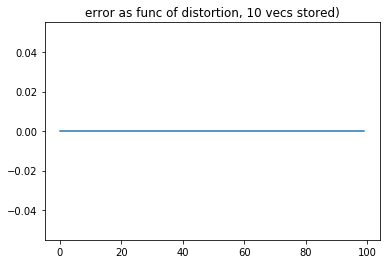

In [151]:
# Store 10 vectors of random data
dim = 10
hn_cap = HebianNet()
trainingData = create_random_data(dim)
hn_cap.train(trainingData)
errors = []
for percentage in range(100):
    percentage = percentage/100 + 0.01
    dist_pic = distort_data(trainingData[0], percentage)
    errors.append(calc_error(trainingData[0],dist_pic))
plt.plot(errors)
plt.title("error as func of distortion, {} vecs stored)".format(dim))
plt.show()

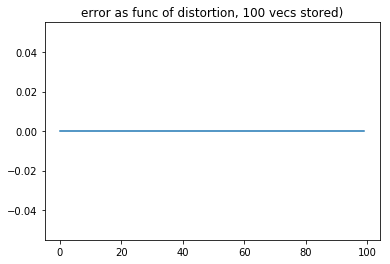

In [152]:
# Store 100 vectors of random data
dim = 100
hn_cap = HebianNet()
trainingData = create_random_data(dim)
hn_cap.train(trainingData)
errors = []
for percentage in range(100):
    percentage = percentage/100 + 0.01
    dist_pic = distort_data(trainingData[0], percentage)
    errors.append(calc_error(trainingData[0], dist_pic))
plt.plot(errors)
plt.title("error as func of distortion, {} vecs stored)".format(dim))
plt.show()

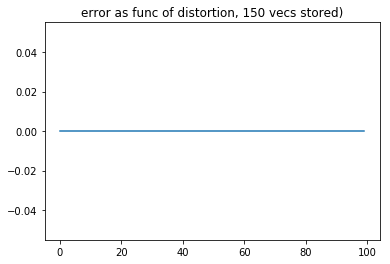

In [153]:
# Store 150 vectors of random data
dim = 150
hn_cap = HebianNet()
trainingData = create_random_data(dim)
hn_cap.train(trainingData)
errors = []
for percentage in range(100):
    percentage = percentage/100 + 0.01
    dist_pic = distort_data(trainingData[0], percentage)
    errors.append(calc_error(trainingData[0], dist_pic))
plt.plot(errors)
plt.title("error as func of distortion, {} vecs stored)".format(dim))
plt.show()

In [56]:
def calc_sparse_error(true_pattern, recalled):
    res = np.subtract(true_pattern, recalled)
    return np.count_nonzero(res)/len(res)*100

In [57]:
def show_sparse(activity, veccount):
    sparseNet = HebianNet()
    trainingData = pictData[0:veccount].copy()
    trainingData[trainingData<0] = 0
    sparseNet.sparse_train(data = trainingData, activity = activity)
    error = []
    biaslist = []
    for bias in range(10):
        bias = bias/10
        recalled = sparseNet.recall(trainingData[0], method = 'sparse', theta = bias)[0]
        error.append(calc_sparse_error(trainingData[0],recalled))
        biaslist.append(bias)
    return error, biaslist

In [58]:
e1, biaslist = show_sparse(activity=0.1, veccount = 3)

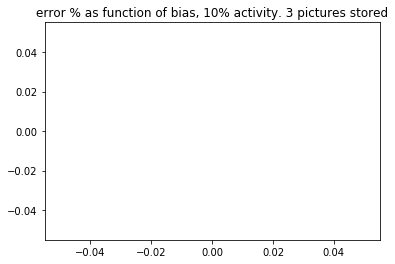

In [59]:
plt.plot(biaslist, e1)
plt.title("error % as function of bias, {}% activity. {} pictures stored".format(10, 3))
plt.show()

In [60]:
e2, biaslist = show_sparse(activity=0.1, veccount = 5)

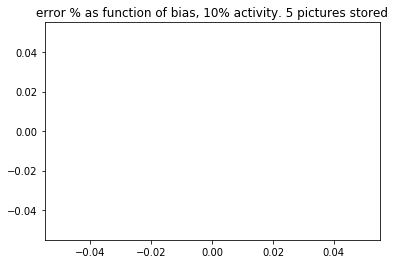

In [61]:
plt.plot(biaslist, e2)
plt.title("error % as function of bias, {}% activity. {} pictures stored".format(10, 5))
plt.show()